In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from time import time
from sklearn.pipeline import Pipeline
from matplotlib import ticker, cm
# from scipy.sparse import csr_matrix


from swimnetworks import (Dense, Linear)
np.set_printoptions(threshold=np.inf)

In [2]:
def tanh_x(x):
    """First derivative of tanh.
    """
    x = np.clip(x, -10, 10)
    return 1/np.cosh(x)**2

def tanh_xx(x):
    x = np.clip(x, -10, 10)
    return -2*np.tanh(x)*(1-np.tanh(x)**2)


In [59]:
# setup the problem ODE
def u_true(x):
    # return np.sin(x[:,0])*np.exp(-x[:,1])
    # return np.exp(-(x[:,0])**2 -(x[:,1])**2)
    return np.sin(10*x[:,0]) + np.sin(10*x[:,1])
    return x[:,0]**5 - 5*x[:,0]**4 + 5*x[:,0]**3 + 5*x[:,0]**2 - 6*x[:,0]
    return np.sin(15*x[:,0])*np.exp(-1.5*x[:,0]) + 5

def u_true_laplacian(x):
    # return 0*x[:,0] + 0*x[:,1]
    # return (4*x[:,0]**2-2)*np.exp(-x[:,0]**2-x[:,1]**2)+(4*x[:,1]**2-2)*np.exp(-x[:,0]**2-x[:,1]**2)
    return -100*np.sin(10*x[:,0]) - 100*np.sin(10*x[:,1])
    return 20*x[:,0]**3 - 60*x[:,0]**2 + 30*x[:,0] + 10
    return -np.exp(-1.5*x[:,0])*(222.75*np.sin(15*x[:,0]) + 45*np.cos(15*x[:,0]))



In [60]:
activation = np.tanh
activation_x = tanh_x
activation_xx = tanh_xx

def solve_PDE_coarse(internal_points_subdomain, boundary_points_subdomain, shared_points_subdomain, subdomains, u_true_train, u_laplacian_train, u_boundary_train, subdomain_layer_widths, neighbor_list, random_state=1):
    """Construct a list of PINNs that solve a simple ode over a decomposed domain.
    The ode to solve is $u_xx + u_yy =f(x,y)$, for $x$ in 2D with domain decomposition."""
    # construct good basis functions by sampling activation functions based on the known data
    # we must run over all domains and create models for each
    def fit_model(inner_train, boundary_train, shared_train, i):
        model_ansatz = Pipeline([
            ("hidden", Dense(
                layer_width=subdomain_layer_widths[i],
                activation=activation,
                parameter_sampler='tanh',
                random_seed=random_state)),
            ("linear", Linear(regularization_scale=1e-10))]
        )
        model_ansatz.fit(inner_train, u_laplacian_train[i])
        # model_ansatz.fit(inner_train, np.zeros_like(u_laplacian_train[i]))
        # model_ansatz.fit(inner_train, u_true_train[i])

        hidden_layer = model_ansatz.steps[0][1]

        # first, evaluate the gradient of the ansatz function
        hidden_layer.activation = activation_xx

        u_xx = hidden_layer.predict(inner_train) * hidden_layer.weights[0,:] * hidden_layer.weights[0,:]
        u_yy = hidden_layer.predict(inner_train) * hidden_layer.weights[1,:] * hidden_layer.weights[1,:]

        uxy = u_xx + u_yy

        # evaluate it on the boundary as well
        hidden_layer.activation = activation
        u_boundary = np.empty((0,0))
        if not boundary_train is None:
            u_boundary = hidden_layer.predict(boundary_train)
    
        u_shared = []
        u_shared_gradx = []
        u_shared_grady = []
        for j in range(len(shared_train)):
            u_shared.append(np.array(hidden_layer.predict(shared_train[j])))

        hidden_layer.activation = activation_x
        for j in range(len(shared_train)):
            u_shared_gradx.append(np.array(hidden_layer.predict(shared_train[j])) * hidden_layer.weights[0,:])
            u_shared_grady.append(np.array(hidden_layer.predict(shared_train[j])) * hidden_layer.weights[1,:])

        hidden_layer.activation = activation

        return model_ansatz, uxy, u_boundary, u_shared, u_shared_gradx, u_shared_grady

    model_data = []
    n_rows = 0
    n_columns = 0
    shared_rows = 0

    for i in range(len(subdomains)):
        model_data.append(fit_model(internal_points_subdomain[i], boundary_points_subdomain[i], shared_points_subdomain[i], i))

        n_rows += model_data[i][1].shape[0] + model_data[i][2].shape[0]
        if (len(shared_points_subdomain[i])>0):
            for arr in shared_points_subdomain[i]:
                shared_rows += arr.shape[0]
        n_columns += subdomain_layer_widths[i]+1
    
    shared_rows = int(shared_rows/2)*3
    print("Model fit using SWIM")

    n_rows += shared_rows
    # setup the linear system inputs and outputs
    # also add the bias term
    matrix_in = np.zeros((int(n_rows), n_columns))
    matrix_out = np.empty((0, 1))

    # For internal and boundary points
    row_start = 0
    column_start = 0
    for i in range(len(subdomains)):
        n_row = model_data[i][1].shape[0]
        matrix_in[row_start:row_start+n_row, column_start:(column_start+subdomain_layer_widths[i]+1)] = np.column_stack([model_data[i][1], np.zeros(model_data[i][1].shape[0])])
        row_start += n_row
        n_row = model_data[i][2].shape[0]
        matrix_in[row_start:row_start+n_row, column_start:(column_start+subdomain_layer_widths[i]+1)] = np.column_stack([model_data[i][2], np.ones(model_data[i][2].shape[0])])
        row_start += n_row
        column_start += subdomain_layer_widths[i]+1

    # For shared points
    column_start = 0
    subdomain_parsed = []
    for i in range(len(subdomains)):   
        for j in range(len(model_data[i][3])):
            neighbor_column_start = 0
            if not neighbor_list[i][j] in subdomain_parsed:
                neighbor_id = neighbor_list[i][j]
                ith_domain = neighbor_list[neighbor_id].index(i)
                for k in range(neighbor_list[i][j]):
                    neighbor_column_start += subdomain_layer_widths[k]+1
                n_row = model_data[i][3][j].shape[0]
                matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][3][j], np.ones((model_data[i][3][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+subdomain_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][3][ith_domain], -np.ones((model_data[neighbor_id][3][ith_domain].shape[0],1))]) 
                row_start += n_row
                matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][4][j], np.zeros((model_data[i][4][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+subdomain_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][4][ith_domain], -np.zeros((model_data[neighbor_id][4][ith_domain].shape[0],1))]) 
                row_start += n_row
                matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][5][j], np.zeros((model_data[i][5][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+subdomain_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][5][ith_domain], -np.zeros((model_data[neighbor_id][5][ith_domain].shape[0],1))]) 
                row_start += n_row
                
        column_start += subdomain_layer_widths[i]+1
        subdomain_parsed.append(i)
            
    # print("Matrix_in created")
    # construct the output matrix for gradient and boundary points
    for i in range(len(subdomains)):
        matrix_out = np.row_stack([
            matrix_out,
            u_laplacian_train[i],
            u_boundary_train[i],
        ])

    # # print(matrix_out)
    # # # append output matrix for shared points
    matrix_out = np.row_stack([
                    matrix_out,
                    np.zeros((shared_rows,1))
                ])

    print("Matrix_out created")
    print("Solving linear system of equations")
    
    # solve
    ## Comapring solvers:
    # 1. numpy least squares solver
    # 2. scipy least squares solver
    # 3. scipy sparse least squares solver
    # 4. scipy optimize least squares
    ## At the moment scipy optimize least square works the best with simiar accuracy and comparable time

    matrix_in_sparse = sp.sparse.csr_matrix(matrix_in)

    # c = spsolve(matrix_in_sparse, matrix_out)

    # c = np.linalg.lstsq(matrix_in, matrix_out, rcond=1e-10)[0]

    # c = sp.linalg.lstsq(matrix_in, matrix_out, cond=1e-10)[0]

    # matrix_in_sparse = sp.sparse.csr_matrix(matrix_in)
    # c = sp.sparse.linalg.lsqr(matrix_in_sparse, matrix_out)[0]#, damp=0.0, atol=1e-06, btol=1e-06, conlim=100000000.0, iter_lim=None, show=False, calc_var=False, x0=None)
    
    ## Exact lsq solver cant be used with sparse matrix
    ## bvls method cannot be used with sparse matrix
    matrix_out = matrix_out.squeeze()
    c = sp.optimize.lsq_linear(matrix_in, matrix_out, tol=1e-10, lsq_solver='exact').x 

    print("Solving completed")

    row_start = 0
    c_subdomain = []
    for i in range(len(subdomains)):
        c_subdomain.append(c[row_start:row_start+subdomain_layer_widths[i]+1])
        model_data[i][0].steps[1][1].weights = c_subdomain[i][:-1]
        model_data[i][0].steps[1][1].biases = c_subdomain[i][-1]
        row_start += subdomain_layer_widths[i]+1

    def combined_model(points):
        x = points[:,0]
        y = points[:,1]
        model_pred = np.zeros((points.shape[0],1))
        mask_domain = np.ones((points.shape[0],1), dtype=bool)
        print(mask_domain.shape)
        for i in range(len(subdomains)):
            if subdomains[i]["type"] == "rectangle": 
                vertices = np.array(subdomains[i]["vertices"])
                mask = (vertices[0][0] <= x) & (x <= vertices[2][0]) & (y >= vertices[0][1]) & (y <= vertices[2][1])
                mask = mask.reshape(-1,1)
                mask_domain = mask_domain * (~mask) 
                model_pred += model_data[i][0].predict(points).reshape(-1,1) * mask
            elif subdomains[i]["type"] == "circle":
                center = np.array(subdomains[i]["center"])
                radius = subdomains[i]["radius"]
                mask = np.array(np.linalg.norm(points - center, axis=1) <= radius)
                mask = mask.reshape(-1,1)
                mask_domain = mask_domain * (~mask)
                model_pred += model_data[i][0].predict(points) * mask
            elif subdomains[i]["type"] == "domain":
                model_pred += model_data[i][0].predict(points) * mask_domain
        
        return model_pred

    return combined_model



def solve_PDE_coarse_correction(model_coarse, internal_points_subdomain, boundary_points_subdomain, shared_points_subdomain, subdomains, u_true_train, u_laplacian_train, u_boundary_train, subdomain_layer_widths, neighbor_list, random_state=1):
    """Construct a list of PINNs that solve a simple ode over a decomposed domain.
    The ode to solve is $u_xx + u_yy =f(x,y)$, for $x$ in 2D with domain decomposition."""
    # construct good basis functions by sampling activation functions based on the known data
    # we must run over all domains and create models for each
    def fit_model(inner_train, boundary_train, shared_train, i):
        model_ansatz = Pipeline([
            ("hidden", Dense(
                layer_width=subdomain_layer_widths[i],
                activation=activation,
                parameter_sampler='tanh',
                random_seed=random_state)),
            ("linear", Linear(regularization_scale=1e-10))]
        )
        model_ansatz.fit(inner_train, u_laplacian_train[i])
        # model_ansatz.fit(inner_train, np.zeros_like(u_laplacian_train[i]))
        # model_ansatz.fit(inner_train, u_true_train[i])

        hidden_layer = model_ansatz.steps[0][1]

        # first, evaluate the gradient of the ansatz function
        hidden_layer.activation = activation_xx

        u_xx = hidden_layer.predict(inner_train) * hidden_layer.weights[0,:] * hidden_layer.weights[0,:]
        u_yy = hidden_layer.predict(inner_train) * hidden_layer.weights[1,:] * hidden_layer.weights[1,:]

        uxy = u_xx + u_yy

        # evaluate it on the boundary as well
        hidden_layer.activation = activation
        u_boundary = np.empty((0,0))
        if not boundary_train is None:
            u_boundary = hidden_layer.predict(boundary_train)
    
        u_shared = []
        u_shared_gradx = []
        u_shared_grady = []
        for j in range(len(shared_train)):
            u_shared.append(np.array(hidden_layer.predict(shared_train[j])))

        hidden_layer.activation = activation_x
        for j in range(len(shared_train)):
            u_shared_gradx.append(np.array(hidden_layer.predict(shared_train[j])) * hidden_layer.weights[0,:])
            u_shared_grady.append(np.array(hidden_layer.predict(shared_train[j])) * hidden_layer.weights[1,:])

        hidden_layer.activation = activation

        return model_ansatz, uxy, u_boundary, u_shared, u_shared_gradx, u_shared_grady

    model_data = []
    n_rows = 0
    n_columns = 0
    shared_rows = 0

    for i in range(len(subdomains)):
        model_data.append(fit_model(internal_points_subdomain[i], boundary_points_subdomain[i], shared_points_subdomain[i], i))

        n_rows += model_data[i][1].shape[0] + model_data[i][2].shape[0]
        if (len(shared_points_subdomain[i])>0):
            for arr in shared_points_subdomain[i]:
                shared_rows += arr.shape[0]
        n_columns += subdomain_layer_widths[i]+1
    
    shared_rows = int(shared_rows/2)*3
    print("Model fit using SWIM")

    n_rows += shared_rows
    # setup the linear system inputs and outputs
    # also add the bias term
    matrix_in = np.zeros((int(n_rows), n_columns))
    matrix_out = np.empty((0, 1))

    # For internal and boundary points
    row_start = 0
    column_start = 0
    for i in range(len(subdomains)):
        n_row = model_data[i][1].shape[0]
        matrix_in[row_start:row_start+n_row, column_start:(column_start+subdomain_layer_widths[i]+1)] = np.column_stack([model_data[i][1], np.zeros(model_data[i][1].shape[0])])
        row_start += n_row
        n_row = model_data[i][2].shape[0]
        matrix_in[row_start:row_start+n_row, column_start:(column_start+subdomain_layer_widths[i]+1)] = np.column_stack([model_data[i][2], np.ones(model_data[i][2].shape[0])])
        row_start += n_row
        column_start += subdomain_layer_widths[i]+1

    # For shared points
    column_start = 0
    subdomain_parsed = []
    for i in range(len(subdomains)):   
        for j in range(len(model_data[i][3])):
            neighbor_column_start = 0
            if not neighbor_list[i][j] in subdomain_parsed:
                neighbor_id = neighbor_list[i][j]
                ith_domain = neighbor_list[neighbor_id].index(i)
                for k in range(neighbor_list[i][j]):
                    neighbor_column_start += subdomain_layer_widths[k]+1
                n_row = model_data[i][3][j].shape[0]
                matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][3][j], np.ones((model_data[i][3][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+subdomain_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][3][ith_domain], -np.ones((model_data[neighbor_id][3][ith_domain].shape[0],1))]) 
                row_start += n_row
                matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][4][j], np.zeros((model_data[i][4][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+subdomain_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][4][ith_domain], -np.zeros((model_data[neighbor_id][4][ith_domain].shape[0],1))]) 
                row_start += n_row
                matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][5][j], np.zeros((model_data[i][5][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+subdomain_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][5][ith_domain], -np.zeros((model_data[neighbor_id][5][ith_domain].shape[0],1))]) 
                row_start += n_row
                
        column_start += subdomain_layer_widths[i]+1
        subdomain_parsed.append(i)
            
    # print("Matrix_in created")
    # construct the output matrix for gradient and boundary points
    for i in range(len(subdomains)):
        matrix_out = np.row_stack([
            matrix_out,
            u_laplacian_train[i],
            u_boundary_train[i],
        ])

    # # print(matrix_out)
    # # # append output matrix for shared points
    matrix_out = np.row_stack([
                    matrix_out,
                    np.zeros((shared_rows,1))
                ])

    print("Matrix_out created")
    print("Solving linear system of equations")
    
    # solve
    ## Comapring solvers:
    # 1. numpy least squares solver
    # 2. scipy least squares solver
    # 3. scipy sparse least squares solver
    # 4. scipy optimize least squares
    ## At the moment scipy optimize least square works the best with simiar accuracy and comparable time

    matrix_in_sparse = sp.sparse.csr_matrix(matrix_in)

    # c = spsolve(matrix_in_sparse, matrix_out)

    # c = np.linalg.lstsq(matrix_in, matrix_out, rcond=1e-10)[0]

    # c = sp.linalg.lstsq(matrix_in, matrix_out, cond=1e-10)[0]

    # matrix_in_sparse = sp.sparse.csr_matrix(matrix_in)
    # c = sp.sparse.linalg.lsqr(matrix_in_sparse, matrix_out)[0]#, damp=0.0, atol=1e-06, btol=1e-06, conlim=100000000.0, iter_lim=None, show=False, calc_var=False, x0=None)
    
    ## Exact lsq solver cant be used with sparse matrix
    ## bvls method cannot be used with sparse matrix
    matrix_out = matrix_out.squeeze()
    c = sp.optimize.lsq_linear(matrix_in, matrix_out, tol=1e-10, lsq_solver='exact').x 

    print("Solving completed")

    row_start = 0
    c_subdomain = []
    for i in range(len(subdomains)):
        c_subdomain.append(c[row_start:row_start+subdomain_layer_widths[i]+1])
        model_data[i][0].steps[1][1].weights = c_subdomain[i][:-1]
        model_data[i][0].steps[1][1].biases = c_subdomain[i][-1]
        row_start += subdomain_layer_widths[i]+1

    def combined_model(points):
        x = points[:,0]
        y = points[:,1]
        model_pred = np.zeros((points.shape[0],1))
        mask_domain = np.ones((points.shape[0],1), dtype=bool)
        print(mask_domain.shape)
        for i in range(len(subdomains)):
            if subdomains[i]["type"] == "rectangle": 
                vertices = np.array(subdomains[i]["vertices"])
                mask = (vertices[0][0] <= x) & (x <= vertices[2][0]) & (y >= vertices[0][1]) & (y <= vertices[2][1])
                mask = mask.reshape(-1,1)
                mask_domain = mask_domain * (~mask) 
                model_pred += model_data[i][0].predict(points).reshape(-1,1) * mask
            elif subdomains[i]["type"] == "circle":
                center = np.array(subdomains[i]["center"])
                radius = subdomains[i]["radius"]
                mask = np.array(np.linalg.norm(points - center, axis=1) <= radius)
                mask = mask.reshape(-1,1)
                mask_domain = mask_domain * (~mask)
                model_pred += model_data[i][0].predict(points) * mask
            elif subdomains[i]["type"] == "domain":
                model_pred += model_data[i][0].predict(points) * mask_domain
        
        return model_pred

    return combined_model


In [61]:
def function_to_generate_points(domain, num_points_subdomain, num_pts_boundary, gridDD, random_state, nx=1, ny=1):
    rng = np.random.default_rng(random_state)

    domain_vertices = np.array(domain["vertices"])

    gridDD=True

    if gridDD:
        nx=nx
        ny=ny
        x_sep=np.linspace(domain_vertices[0][0], domain_vertices[2][0], nx+1)
        y_sep=np.linspace(domain_vertices[0][1], domain_vertices[2][1], ny+1)
        # x_sep=[-np.pi, -2.355, -1.57, -0.785, 0, 0.785, 1.57, 2.355, np.pi]
        # y_sep=[-np.pi, -2.355, -1.57, -0.785, 0, 0.785, 1.57, 2.355, np.pi]
        # y_sep = [-np.pi, np.pi]
        subdomains = []
        for j in range(ny):
            for i in range(nx):
                dict = {}
                vertex_list = [(x_sep[i], y_sep[j]), (x_sep[i], y_sep[j+1]), (x_sep[i+1], y_sep[j+1]), (x_sep[i+1], y_sep[j])]
                dict = {"type": "rectangle", "vertices": vertex_list}
                subdomains.append(dict)

    else:
        ## Add subdomains by specifying type and geometry information
        ## Currently shared boundary subdomains is only implemented for type:rectangle subdomains
        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, -1.5), (-1.5, -1.5), (-1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (1.5, -1.5), (1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(1.5, -np.pi), (1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, -1.5), (-np.pi, 1.5), (-1.5, 1.5), (-1.5, -1.5)]},  
        #     {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, -1.5), (1.5, 1.5), (np.pi, 1.5), (np.pi, -1.5)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (-1.5, np.pi), (-1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(-1.5, 1.5), (-1.5, np.pi), (1.5, np.pi), (1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, 1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, 1.5)]},
        #     # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, -1.5), (-1.5, -1.5), (-1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (0, -1.5), (0, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(0, -np.pi), (0, -1.5), (1.5, -1.5), (1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(1.5, -np.pi), (1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, -1.5), (-np.pi, 1.5), (-1.5, 1.5), (-1.5, -1.5)]},  
        #     {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, -1.5), (1.5, 1.5), (np.pi, 1.5), (np.pi, -1.5)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (-1.5, np.pi), (-1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(-1.5, 1.5), (-1.5, np.pi), (1.5, np.pi), (1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, 1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, 1.5)]},
        #     # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, -1.5), (-1.5, -1.5), (-1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (1.5, -1.5), (1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(1.5, -np.pi), (1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, -1.5), (-np.pi, 1.5), (0, 1.5), (0, -1.5)]},  
        #     {"type": "rectangle", "vertices": [(0, -1.5), (0, 1.5), (np.pi, 1.5), (np.pi, -1.5)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (-1.5, np.pi), (-1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(-1.5, 1.5), (-1.5, np.pi), (1.5, np.pi), (1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, 1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, 1.5)]},
        #     # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

        subdomains = [
            # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
            {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, 1.5), (-1.5, 1.5), (-1.5, -np.pi)]},
            {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
            {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
            {"type": "rectangle", "vertices": [(1.5, -1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, -1.5)]},
            {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (1.5, np.pi), (1.5, 1.5)]},  
            
            # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
            # {"type": "circle", "center": (0, 0), "radius": 0.5},
            # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        ]

        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
            
        #     {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

    def is_inside_subdomain(point, subdomain):
        """Helper function to check whether a coordinate is inside a subdomain."""

        if subdomain["type"] == "rectangle":
            vertices = np.array(subdomain["vertices"])
            return np.all(vertices[0] < point) and np.all(point < vertices[2])
        elif subdomain["type"] == "circle":
            center = np.array(subdomain["center"])
            radius = subdomain["radius"]
            return np.linalg.norm(point - center) < radius
        else:
            return False

    def generate_points_domain(domain, subdomains, num_points):
        """Samples points inside the domain but outside all the subdomains."""

        points = []
        if domain["type"] == "rectangle":
            while len(points) < num_points:
                point = rng.uniform(
                    low=(domain["vertices"][0]),
                    high=(domain["vertices"][2]),
                )
                if not any(is_inside_subdomain(point, subdomain) for subdomain in subdomains):
                    points.append(point)

        elif domain["type"] == "circle":
            center = np.array(domain["center"])
            radius = domain["radius"]
            while len(points) < num_points:
                r = np.sqrt(rng.uniform(0, 1, size=num_points)) * radius
                theta = rng.uniform(0, 2 * np.pi, size=num_points)
                point = center + np.column_stack((r * np.cos(theta), r * np.sin(theta)))
                if not any(is_inside_subdomain(point, subdomain) for subdomain in subdomains):
                    points.append(point)

        return points

    def generate_points_subdomain(subdomain, num_points):
        """Generate points inside the subdomain based on the geometry information of the subdomain."""

        if subdomain["type"] == "rectangle":
            vertices = np.array(subdomain["vertices"])
            min_x, min_y = np.min(vertices, axis=0)
            max_x, max_y = np.max(vertices, axis=0)
            points = rng.uniform(low=(min_x, min_y), high=(max_x, max_y), size=(num_points, 2))
        elif subdomain["type"] == "circle":
            center = np.array(subdomain["center"])
            radius = subdomain["radius"]
            r = np.sqrt(rng.uniform(0, 1, size=num_points)) * radius
            theta = rng.uniform(0, 2 * np.pi, size=num_points)
            points = center + np.column_stack((r * np.cos(theta), r * np.sin(theta)))
        else:
            points = np.array([])  
        return points

    def generate_boundary_points(subdomain, num_points):
        """Generate points on the boundary of the subdomain. (Currently used to sample points from the boundary of the overall domain)"""

        boundary_points = []
        if subdomain["type"] == "rectangle":
            vertices = np.array(subdomain["vertices"])
            for i in range(len(vertices)):
                p1 = vertices[i]
                p2 = vertices[(i + 1) % len(vertices)]
                boundary_points.extend(
                    [p1 + t * (p2 - p1) for t in np.linspace(0, 1, int(num_points/4), endpoint=False)]
                )
            boundary_points = np.array(boundary_points)
        elif subdomain["type"] == "circle":
            theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
            boundary_points = subdomain["center"] + subdomain["radius"] * np.column_stack((np.cos(theta), np.sin(theta)))
        else:
            boundary_points = []  
        return boundary_points

    def find_neighboring_subdomains(subdomain):
        """Function to sample shared points between subdomains and generate a list containing neighboring information."""

        shared_points_subdomain = {}
        neighboring_subdomains = {}
        shared_points_perunitlength = 10  #### For future sample shared points based on the size of the shared boundary
        for i, sub1 in enumerate(subdomain):
            neighbors = []
            shared_points = []
            vertices1 = np.array(sub1["vertices"])
            for j, sub2 in enumerate(subdomain):
                if i != j: 
                    vertices2 = np.array(sub2["vertices"])
                    x_touching = (min(vertices1[2][0], vertices2[2][0]) == max(vertices1[0][0], vertices2[0][0])) and (min(vertices1[2][1], vertices2[2][1]) > max(vertices1[0][1], vertices2[0][1]))
                    y_shared_x_touching = [max(vertices1[0][1], vertices2[0][1]), min(vertices1[2][1], vertices2[2][1])]
                    x_shared_x_touching = vertices1[0][0]*(vertices1[0][0] == vertices2[2][0]) + vertices1[2][0]*(vertices1[2][0] == vertices2[0][0])
                    y_touching = (min(vertices1[2][1], vertices2[2][1]) == max(vertices1[0][1], vertices2[0][1])) and (min(vertices1[2][0], vertices2[2][0]) > max(vertices1[0][0], vertices2[0][0]))
                    x_shared_y_touching = [max(vertices1[0][0], vertices2[0][0]), min(vertices1[2][0], vertices2[2][0])]
                    y_shared_y_touching = vertices1[0][1]*(vertices1[0][1] == vertices2[2][1]) + vertices1[2][1]*(vertices1[2][1] == vertices2[0][1])

                    if (x_touching or y_touching):
                        # if j not in neighboring_subdomains: 
                        neighbors.append(j)
                        if (x_touching):
                            points_to_sample = int((y_shared_x_touching[1] - y_shared_x_touching[0])*shared_points_perunitlength)  
                            shared_coordinates = np.column_stack([np.ones(points_to_sample)*x_shared_x_touching, np.linspace(y_shared_x_touching[0], y_shared_x_touching[1],points_to_sample)])
                            shared_points.append(shared_coordinates)
                        if (y_touching):
                            points_to_sample = int((x_shared_y_touching[1] - x_shared_y_touching[0])*shared_points_perunitlength)   
                            shared_coordinates = np.column_stack([np.linspace(x_shared_y_touching[0], x_shared_y_touching[1],points_to_sample), np.ones(points_to_sample)*y_shared_y_touching])
                            shared_points.append(shared_coordinates)

            # if neighbors:      
            shared_points_subdomain[i] = shared_points
            
            neighboring_subdomains[i] = neighbors

        return shared_points_subdomain, neighboring_subdomains

    internal_points_subdomain = []
    for i,sub in enumerate(subdomains):
        if sub["type"] == "rectangle":
            internal_points_subdomain.append(np.array(generate_points_subdomain(sub, num_points_subdomain[i])))
        elif sub["type"] == "domain":
            internal_points_subdomain.append(np.array(generate_points_domain(domain, subdomains, num_points_subdomain[i])))

    boundary_points_domain = generate_boundary_points(domain, int(num_pts_boundary))
    boundary_points_domain = np.array(boundary_points_domain)   #### Generates overall boundary points distribute this to the domains with boundary information

    if domain["type"] == "rectangle":
        boundary_points_subdomain = []
        #Boundary points
        for sub in subdomains:
            boundary_points = []
            if sub["type"] == "rectangle":
                vertices = np.array(sub["vertices"])
                if vertices[0][0] == domain_vertices[0][0]:
                    mask = np.logical_and.reduce([
                        boundary_points_domain[:, 0] == vertices[0][0],
                        boundary_points_domain[:, 1] >= vertices[0][1],
                        boundary_points_domain[:, 1] <= vertices[2][1]
                    ])
                    boundary_points.append(boundary_points_domain[mask])
                    boundary_points_domain = np.delete(boundary_points_domain, mask, axis = 0)
                if vertices[2][0] == domain_vertices[2][0]:
                    mask = np.logical_and.reduce([
                        boundary_points_domain[:, 0] == vertices[2][0],
                        boundary_points_domain[:, 1] >= vertices[0][1],
                        boundary_points_domain[:, 1] <= vertices[2][1]
                    ])
                    boundary_points.append(boundary_points_domain[mask])
                    boundary_points_domain = np.delete(boundary_points_domain, mask, axis = 0)
                if vertices[0][1] == domain_vertices[0][1]:
                    mask = np.logical_and.reduce([
                        boundary_points_domain[:, 1] == vertices[0][1],
                        boundary_points_domain[:, 0] >= vertices[0][0],
                        boundary_points_domain[:, 0] <= vertices[2][0]
                    ])
                    boundary_points.append(boundary_points_domain[mask])
                    boundary_points_domain = np.delete(boundary_points_domain, mask, axis = 0)
                if vertices[2][1] == domain_vertices[2][1]:
                    mask = np.logical_and.reduce([
                        boundary_points_domain[:, 1] == vertices[2][1],
                        boundary_points_domain[:, 0] >= vertices[0][0],
                        boundary_points_domain[:, 0] <= vertices[2][0]
                    ])
                    boundary_points.append(boundary_points_domain[mask])
                    boundary_points_domain = np.delete(boundary_points_domain, mask, axis = 0)
                
                if boundary_points:
                    boundary_points_subdomain.append(np.concatenate(boundary_points))
                else:
                    boundary_points_subdomain.append(None)
            elif sub["type"] == "domain":
                boundary_points_subdomain.append(boundary_points_domain)

    shared_points_subdomain, neighbor_list = find_neighboring_subdomains(subdomains)

    for i in range(len(subdomains)):
        for k in range(len(shared_points_subdomain[i])):
            internal_points_subdomain[i] = np.row_stack([internal_points_subdomain[i], shared_points_subdomain[i][k]])
        # if not boundary_points_subdomain[i] is None:
        #     internal_points_subdomain[i] = np.row_stack([internal_points_subdomain[i], boundary_points_subdomain[i]])
        

    print(neighbor_list)
    # boundary_subdomain = generate_boundary_points(subdomains[0], 60)
    # shared_points_subdomain[0].append(np.array(boundary_subdomain))

    for i in range(len(subdomains)):
        x_coords = [point[0] for point in internal_points_subdomain[i]]
        y_coords = [point[1] for point in internal_points_subdomain[i]]
        plt.scatter(x_coords, y_coords, s=2)

    for i in range(len(subdomains)):
        if not boundary_points_subdomain[i] is None:
            x_coords = [point[0] for point in boundary_points_subdomain[i]]
            y_coords = [point[1] for point in boundary_points_subdomain[i]]
            plt.scatter(x_coords, y_coords, s=2)

    for i in range(len(subdomains)):
        for j in range(len(shared_points_subdomain[i])):
            x_coords = [point[0] for point in shared_points_subdomain[i][j]]
            y_coords = [point[1] for point in shared_points_subdomain[i][j]]
            plt.scatter(x_coords, y_coords, s=2)


    plt.xlim(domain_vertices[0][0], domain_vertices[2][0])
    plt.ylim(domain_vertices[0][1], domain_vertices[2][1])

    plt.axis('square')

    return subdomains, internal_points_subdomain, boundary_points_subdomain, shared_points_subdomain, neighbor_list



{0: []}
Model fit using SWIM
Matrix_out created
Solving linear system of equations
Solving completed
time taken for coarse solution 0.10751962661743164 seconds.


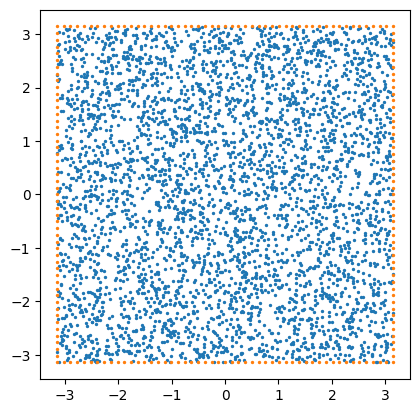

In [68]:
# First find the coarse solution 
domain = {
    "type"    : "rectangle", 
    "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]
}
domain_vertex = np.array(domain["vertices"])

random_state = 1
domain_num_points = [2000]
domain_boundary_points = 200
grid_DD = True
nx = 1
ny = 1
domain_points_neighbor_info = function_to_generate_points(domain, domain_num_points, domain_boundary_points, grid_DD, random_state, nx=nx, ny=ny)
domain_list = domain_points_neighbor_info[0]
internal_points_domain = domain_points_neighbor_info[1]
boundary_points_domain = domain_points_neighbor_info[2]
shared_points_domain = domain_points_neighbor_info[3]
neighbor_list = domain_points_neighbor_info[4]

domain_layer_widths = [125]*len(domain_list)
u_laplacian_train = []
u_true_train = []
u_boundary_train = []

for i in range(len(domain_list)):
    u_laplacian_train.append(u_true_laplacian(internal_points_domain[i]).reshape((-1,1)))
    # u_true_train.append(u_true(internal_points_subdomain[i]).reshape((-1,1)))
    if not boundary_points_domain[i] is None: 
        u_boundary_train.append(u_true(boundary_points_domain[i]).reshape((-1,1)))
    else:
        u_boundary_train.append(np.empty((0,1)))

#  Coarse solution
t0 = time()
model_coarse = solve_PDE_coarse(internal_points_domain, boundary_points_domain, shared_points_domain, domain_list, u_true_train, u_laplacian_train, u_boundary_train, domain_layer_widths, neighbor_list, random_state=1)
print("time taken for coarse solution", time()-t0, "seconds.")

(22500, 1)
Maximum error:  [51.4812549]


Text(0, 0.5, 'y')

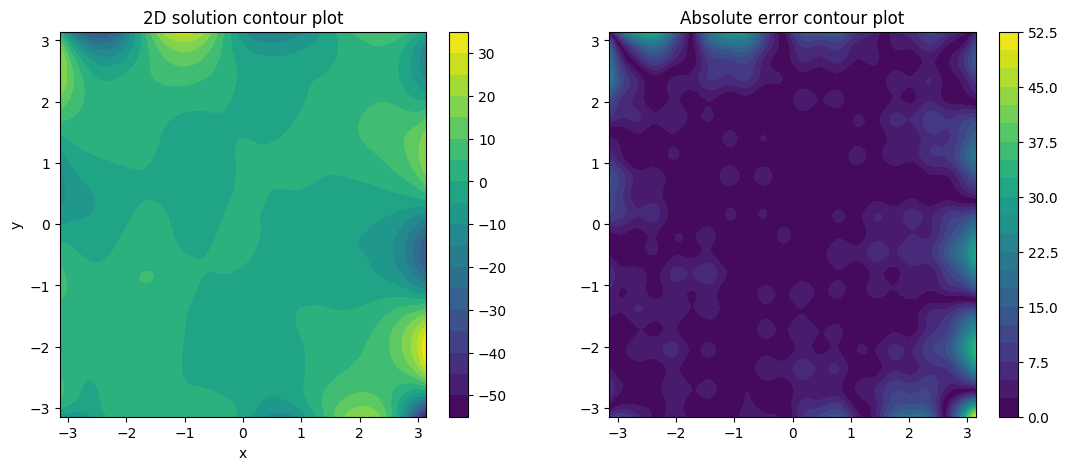

In [69]:
### Error for coarse solution

rng = np.random.default_rng(1)
# lims = [-1*np.pi, 1*np.pi]
n_pts_train = 150
x_lin = np.linspace(domain_vertex[0][0], domain_vertex[2][0], 150)
y_lin = np.linspace(domain_vertex[0][1], domain_vertex[2][1], 150)
x_t, y_t = np.meshgrid(x_lin, y_lin)
# x = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
# y = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
# x_t, y_t = np.meshgrid(x, y)

# solution_1 = np.zeros_like(x_t)
solution = model_coarse(np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)]))

error = np.absolute(u_true(np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)])).reshape(-1,1) - solution)
print("Maximum error: ",max(error))
error = error.reshape(n_pts_train, n_pts_train)

solution = solution.reshape(n_pts_train, n_pts_train)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
contour1 = ax[0].contourf(x_t, y_t, solution, levels=20, cmap='viridis')
contour2 = ax[1].contourf(x_t, y_t, error, levels=20, cmap = 'viridis') 

colorbar = plt.colorbar(contour1, ax=ax[0])
colorbar = plt.colorbar(contour2, ax=ax[1])

ax[0].set_title('2D solution contour plot')
ax[1].set_title('Absolute error contour plot')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

{0: [1, 2], 1: [0, 3], 2: [0, 3], 3: [1, 2]}


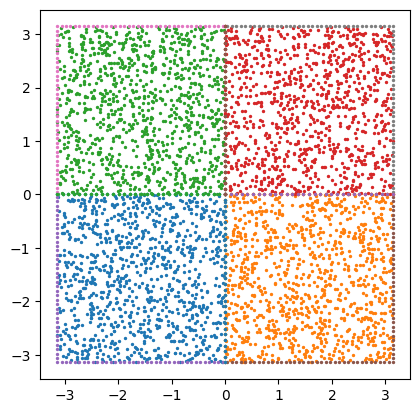

In [53]:
# Improve the coarse solution using DD
subdomain_num_points = [1000,1000,1000,1000]
domain_boundary_points = 300
grid_DD = True
nx = 2
ny = 2
subdomain_points_neighbor_info = function_to_generate_points(domain, subdomain_num_points, domain_boundary_points, grid_DD, random_state, nx=nx, ny=ny)
subdomains = subdomain_points_neighbor_info[0]
internal_points_subdomain = subdomain_points_neighbor_info[1]
boundary_points_subdomain = subdomain_points_neighbor_info[2]
shared_points_subdomain = subdomain_points_neighbor_info[3]
neighbor_list = subdomain_points_neighbor_info[4]

subdomain_layer_widths = [125]*len(subdomains)
u_laplacian_train = []
u_true_train = []
u_boundary_train = []

for i in range(len(domain_list)):
    u_laplacian_train.append(u_true_laplacian(internal_points_subdomain[i]).reshape((-1,1)))
    # u_true_train.append(u_true(internal_points_subdomain[i]).reshape((-1,1)))
    if not boundary_points_domain[i] is None: 
        u_boundary_train.append(u_true(boundary_points_subdomain[i]).reshape((-1,1)))
    else:
        u_boundary_train.append(np.empty((0,1)))

# Coarse corrected solution
t0 = time()
model = solve_PDE_coarse_correction(model_coarse, internal_points_domain, boundary_points_domain, shared_points_domain, domain_list, u_true_train, u_laplacian_train, u_boundary_train, domain_layer_widths, neighbor_list, random_state=1)
print("time taken for coarse solution", time()-t0, "seconds.")
# subdomain_layer_widths = [500]*len(subdomains)#[250,250,250,250,400,200,200,200,200]#[400]*len(subdomains)


In [ ]:
### Error for coarse correction solution

rng = np.random.default_rng(1)
# lims = [-1*np.pi, 1*np.pi]
n_pts_train = 150
x_lin = np.linspace(domain_vertex[0][0], domain_vertex[2][0], 150)
y_lin = np.linspace(domain_vertex[0][1], domain_vertex[2][1], 150)
x_t, y_t = np.meshgrid(x_lin, y_lin)
# x = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
# y = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
# x_t, y_t = np.meshgrid(x, y)

# solution_1 = np.zeros_like(x_t)
solution = model(np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)]))

error = np.absolute(u_true(np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)])).reshape(-1,1) - solution)
print("Maximum error: ",max(error))
error = error.reshape(n_pts_train, n_pts_train)

solution = solution.reshape(n_pts_train, n_pts_train)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
contour1 = ax[0].contourf(x_t, y_t, solution, levels=20, cmap='viridis')
contour2 = ax[1].contourf(x_t, y_t, error, levels=20, cmap = 'viridis') 

colorbar = plt.colorbar(contour1, ax=ax[0])
colorbar = plt.colorbar(contour2, ax=ax[1])

ax[0].set_title('2D solution contour plot')
ax[1].set_title('Absolute error contour plot')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

                                             Accuracy                 Time
numpy least square solver                    0.00027195         6.69196343421936 
scipy optimize sparse least square           0.11518691         4.052311182022095
scipy optimize dense least square            4.85529914e-05     6.864076137542725
scipy sparse least square solver             0.06771056         7.026107549667358

Thesis outline:

- Background theory   
    - Background and related work (Description about methods used to solve pdes using neural network)  
    - Problems associated with conventional methods (Meshing around complex geometries)
    
- Introduction    
    - Short description about the components used to generate solution of the pde or write a short para on the sections in the thesis.  

- Implementation description
    - Sections about different components in the paper for eg: Neural network architecture, Domain decomposition and points sampling, pde conditions (Internal and boundary), constructing the input and output matrices, solving (compare solvers maybe?)  
    -Neural Network 
        - Neural network architecture
        - input and output layers
        - activation function
        - sampling techniques of weights and biases 
    -Domain decomposition and points sampling
        - Description about domain decomposition 2 types implemented (Grid and arbitrary)
        - Points sampled: 1. Internal points, 2. Boundary points, 3. Shared points for each subdomain
    -pde conditions and boundary conditions
        - Equations for internal points and boundary points from neural network output
        - Additional equations for shared points
        - Construction of coefficient matrix and RHS vector
    -solution procedure (Least squares)
    -**Final algorithm to generate solution of pde** 

- Comparison Study ? (Appendix)
    - Comparison study on the effect of changing layer width, internal points sampled and boundary points sampled on the solution accuracy.  

- Problem description and Results or Results as a separate section
    - 1d, 2d problems
    - Each problem gets its section **decide on the problems to solve**  
      
- Results

- Conclusion

- Appendix
    - Experiments 

